In [1]:
%load_ext autoreload
%autoreload 2

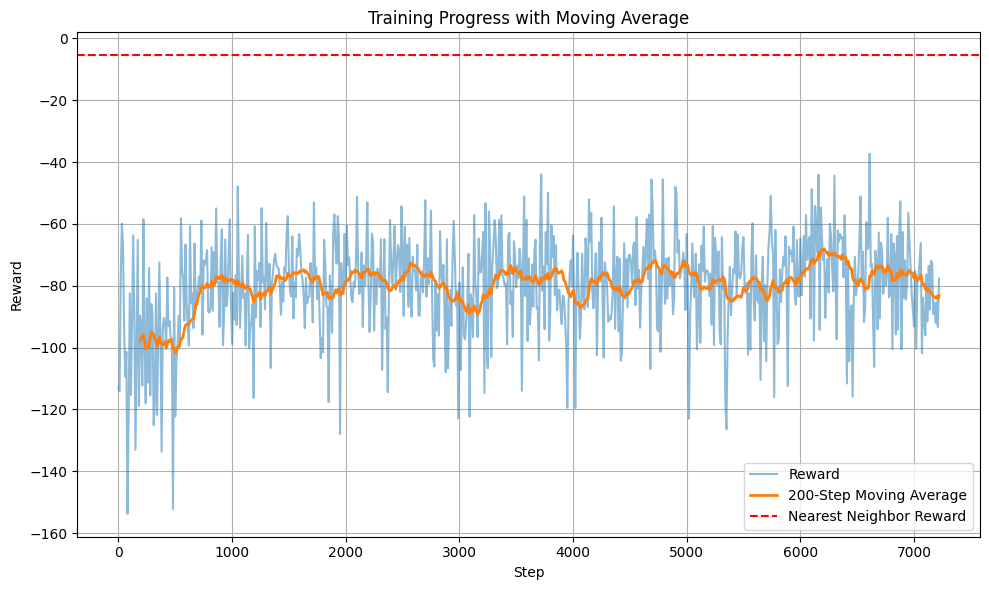

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv('output1.csv')

# Compute moving average with window size 20
window_size = 20
df['moving_avg'] = df['reward'].rolling(window=window_size).mean()

# Plot both raw reward and moving average
plt.figure(figsize=(10, 6))
plt.plot(df['step'], df['reward'], label='Reward', alpha=0.5)
plt.plot(df['step'], df['moving_avg'], label=f'{window_size*10}-Step Moving Average', linewidth=2)

# Add horizontal line for nearest neighbor reward
nearest_neighbor_reward = -5.44
plt.axhline(nearest_neighbor_reward, color='red', linestyle='--', label='Nearest Neighbor Reward')

plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Training Progress with Moving Average')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
from poly_matrix import create_poly_matrix
from new_env import CityEnv


def nearest_neighbors_with_time(travel_tensor, start_node, visit_nodes):
    visit_nodes = visit_nodes.copy()
    path = [start_node]
    current_node = start_node
    current_time = 0
    total_time = 0

    while visit_nodes:
        best_node = None
        best_time = float('inf')
        for node in visit_nodes:
            time_index = min(int(current_time), travel_tensor.shape[2] - 1)
            travel_time = travel_tensor[current_node, node, time_index]
            if travel_time < best_time:
                best_time = travel_time
                best_node = node

        if best_node is None:
            break

        # Update current state
        visit_nodes.remove(best_node)
        current_time += best_time
        total_time += best_time
        path.append(best_node)
        current_node = best_node

    return path, total_time


def discretize_poly_matrix(poly_matrix, N, T=48):
    """
    Discretizes the polynomial travel times into a 3D numpy tensor of shape (N, N, T),
    where each entry [i, j, t] is the travel time from node i to j at time t.
    """
    tensor = np.zeros((N, N, T), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            for t in range(T):
                tensor[i, j, t] = poly_matrix[i, j].eval(t)
    return tensor


def evaluate_policy(policy, poly_matrix, env_test, destinations, seed=50):
    
    obs, _ = env_test.reset(destinations=destinations.copy(), start_time=0, start_vertex=1)
    

    done = False
    total_reward = 0
    actions = []
    for i in range(env_test.max_steps):
        
        action = policy[i] 
        actions.append(action)
        obs, reward, done, _, _ = env_test.step(action)
    
        total_reward += reward
        if done:
            break
    print(actions)
    return total_reward

rewards = []
for i in range(50):
    N = 10
    T = 48
    time_horizon = 24

    poly_matrix = create_poly_matrix(N, time_horizon, seed=50)
    travel_tensor = discretize_poly_matrix(poly_matrix, N, T)

    start_node = 0
    visit_nodes = [1, 2, 4, 6, 8]
    destinations = np.zeros(N)
    destinations[visit_nodes] = 1
    path, total_time = nearest_neighbors_with_time(travel_tensor, start_node, visit_nodes)
    print("Visit path:", path)
    print("Total travel time:", env.current_time)

    env = CityEnv(poly_matrix, N=N, time_horizon=time_horizon, max_steps=200)
    good_path = [9, 17, 19, 5, 1, 7, 15, 13, 11, 3]
    path = path[1:]
    reward = evaluate_policy(path, poly_matrix, env, destinations)
    rewards.append(env.current_time)
print('Average Reward:', np.mean(rewards))







Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404651
[2, 1, 4, 8, 6]
Visit path: [0, 2, 1, 4, 8, 6]
Total travel time: 1.7537604718404

In [ ]:
import torch

# Instantiate the models
N = 10  # or whatever your N is
policy_net = PolicyNetwork(N)
value_net = ValueNetwork(N)

# Load parameters (make sure the paths match your saved files)
policy_net.load_state_dict(torch.load('policy_net.pth'))
value_net.load_state_dict(torch.load('value_net.pth'))

# Move to GPU if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net.to(device)
value_net.to(device)

# Set to eval mode if you're not training
policy_net.eval()
value_net.eval()
